# Example binary system isotherm analysis notebook for FHMCAnalysis
* Author: Nathan A. Mahynski
* Last Modified: 05/02/17

In [21]:
import sys, os
import numpy as np
sys.path.append('../../../../')
import FHMCAnalysis
import FHMCAnalysis.moments.histogram.one_dim.ntot.gc_hist as hG
import FHMCAnalysis.moments.win_patch.chkpt_patch as wP
import FHMCAnalysis.moments.win_patch.chkpt_equil as wE
import FHMCAnalysis.moments.histogram.one_dim.ntot.gc_binary as gB
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

%matplotlib inline

# Define the Fluid

In [2]:
temp = 1.5

In [3]:
head = './'

In [15]:
# Fluid properties (cross from LB rules)
sig11 = 1.00
eps11 = 1.00
sig22 = 1.50
eps22 = 4/3.

### Example of patching procedure
```
trim = 1
smoothOverlap = True
for d in sorted([dd for dd in os.listdir(head) if 'dMu2' in dd]):
    src = head+'/'+d
    seq = wP.get_patch_sequence(src)
    seq = wE.test_nebr_equil(seq, 3.0, src+'/maxEq', True)
    composite = src+'/composite.nc'
    wP.patch_all_windows(seq, composite, src+'/patch.log', trim, smoothOverlap)
```

In [5]:
beta_ref = 1.0/temp # Simulations were performed at 1/T = 0.0
smooth = 60 # How many points in N_tot space to smooth lnPI over when looking for maxima

histograms = []
for d in sorted([dd for dd in os.listdir(head) if 'dMu2' in dd]):
    dMu2 = float(d.split('_')[1])
    mu_ref = [0.0, 0.0+dMu2] # Simulations were performed at mu_1 = 0
    composite = head+'/'+d+'/composite.nc'
    hist = hG.histogram (composite, beta_ref, mu_ref, smooth)
    histograms.append((dMu2,hist))

# Construct Isopleths

In [7]:
target_beta = 1/1.40 # Target temperature
order = 2 # Order of extrapolation

In [9]:
iso = gB.isopleth ([x[1] for x in histograms], target_beta, order) # Construct isopleth object

In [10]:
grid_x1, grid_mu = iso.make_grid_multi([-14, -2], [-4, 4], [0.25, 0.25], m=2.5) # Compute the grid

## Plot Isopleths

(-5, 5)

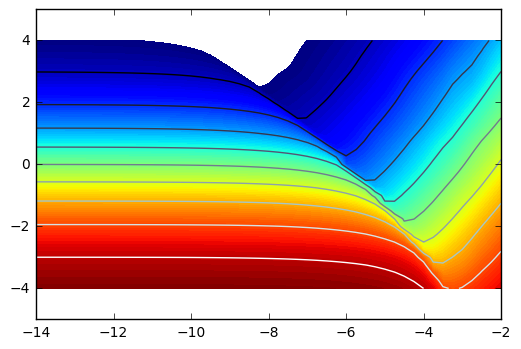

In [11]:
csf = plt.contourf(grid_mu[0], grid_mu[1], grid_x1, levels=np.linspace(0.05, 0.95, 100))
cs = plt.contour(grid_mu[0], grid_mu[1], grid_x1, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], cmap='bone')
plt.ylim(-5,5)

## Extract Some Isopleths for Analysis

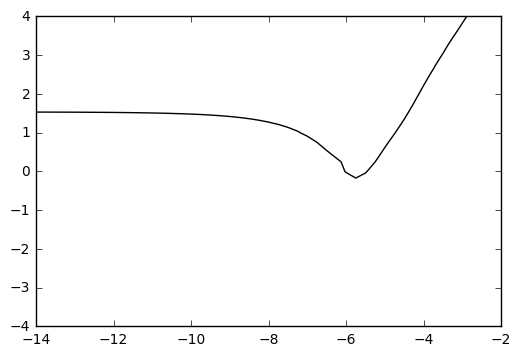

In [12]:
x1 = 0.25 # Chosen isopleth
mu_vals = gB.get_iso (x1, grid_x1, grid_mu[0], grid_mu[1]) # Extract the isopleth

In [16]:
V = 10.0*10.0*10.0 # Volume of simulation cell in example data provided
p = -iso.data['F.E./kT']/V/target_beta # Compute the pressure
phi = np.pi/6.0*((sig11**3)*x1*iso.data['density']+(sig22**3)*(1.0-x1)*iso.data['density']) # Compute the packing fraction

## Plot the Isobars

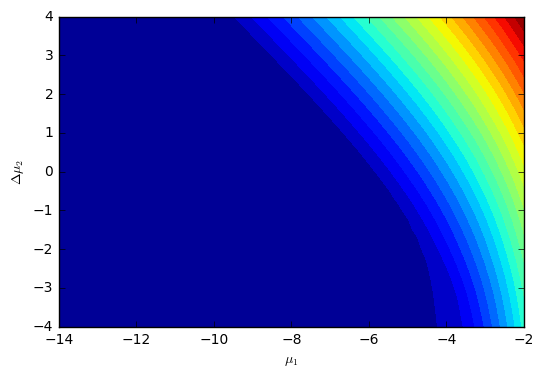

In [20]:
levels=np.linspace(np.min(p), np.max(p), 25)
csf = plt.contourf(grid_mu[0], grid_mu[1], p, levels=levels)
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\Delta \mu_2$')

# Parameterize thermodynamic data

In [22]:
xy = gB.parameterize_mesh (grid_mu[0], grid_mu[1], phi, p, mu_vals) # Parameterize phi in terms of P on the grid

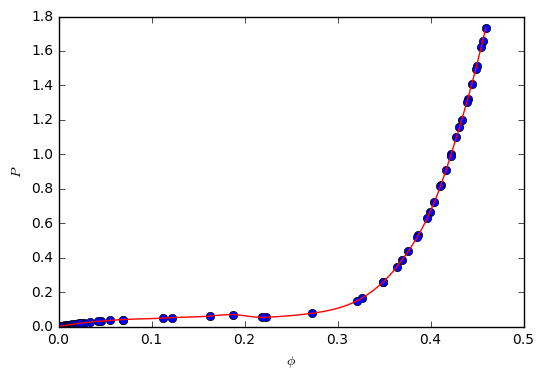

In [23]:
# Plot raw parameterization
phi_v = np.array([x[0] for x in xy])
p_v = np.array([x[1] for x in xy])
plt.plot(phi_v, p_v, 'o')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$P$')

# Interpolate to smooth / use to compute arbitrary results
f = interp1d(phi_v, p_v, kind='cubic')
t = np.linspace(np.min(phi_v), np.max(phi_v), 100)
plt.plot(t, f(t), 'r') 

In [25]:
f(0.35) # Now have python function to interpolate!

array(0.2639112893838169)

# Check Gibbs-Duhem Consistency

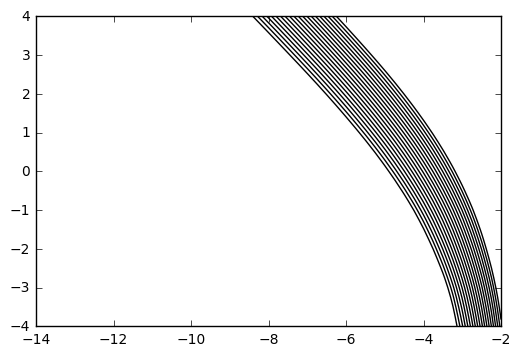

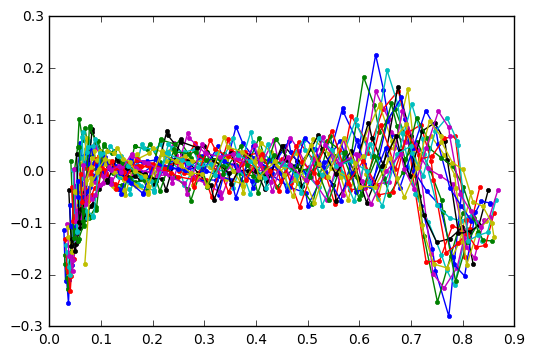

In [26]:
err2 = gB.check_gibbs_duhem(np.linspace(0.3, 0.8, 20), grid_x1, p, grid_mu[0], grid_mu[1])
plt.figure()
for p_, e_, x1_, d_, q_beta in err2:
    plt.plot(x1_, e_, label=str(p_), marker='.', lw=1)